In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

The goal is to predict the winner of any game in the 2017 NBA season.  The file $\texttt{NBA-DATAMINING.csv}$ contains stats for NBA games from 2011 to 2018.  I'll use the data to create a set of features and train a classifier to predict the outcome of any given game.  I'll try a logistic model, because I'm interested in predicting a binary dependent variable.  

Because it makes the exercise more interesting, I'll create a few of my own features.  First, win ratios for both the home and away teams.  Second, for each team, a running total of the points scored in the last 10 games.  Notably, I'll have to keep track of points scored when the team plays at home and on the road.  Finally, I'll adapt the Elo rating system used to rank professional chess players to create an Elo score for each team.  The Elo rating increases when a team wins and decreases when a team loses; the magnitude of each team's gain/loss is proportional to the rating of their opponent.  With appropriately chosen parameters, the Elo rating can be a very good predictor.  

In [2]:
data = pd.read_csv('NBA_DATAMINING.csv')
data.head()

,date,team,points,assists,biggest lead,blocks,defensive rebounds,fast break points,field goals attempted,field goals made,...,o:site,o:site streak,o:steals,o:streak,o:team rebounds,o:three pointers attempted,o:three pointers made,o:turnovers,o:wins,season
0,20091115,Lakers,91,23,14,10,32,18,84,32,...,away,-1,9,-1,8,32,9,19,5,2009
1,20091115,Pistons,90,12,7,6,32,6,83,38,...,away,-2,11,1,7,16,7,7,6,2009
2,20091115,Suns,101,18,7,4,34,10,78,35,...,away,-1,6,2,5,24,9,11,5,2009
3,20091115,Thunder,93,13,3,1,30,10,85,33,...,away,4,9,-3,9,17,5,12,3,2009
4,20091116,Bucks,113,26,2,4,33,18,99,44,...,away,-3,5,2,7,20,10,15,7,2009


Each row has the results of each game.  In order to preict games faithfully we can't steal from the future,
i.e. we can't use the results of the game to predict the outcome.

We also have to make a target column to train the classifier.

In [3]:
def make_target(data):
    """
    Determine which team won; return 1 for home team, 0 for opponent 
    """
        
    if data['points'] > data['o:points']:
        return 1
    else:
        return 0

In [4]:
#  build feature columns

#  make target
data['won'] = data.apply(make_target, axis=1)

#  win ratios for home and opponent
data['win_ratio'] = data['wins'] / data['game number']
data['o:win_ratio'] = data['o:wins'] / data['game number']

#  sum of points in previous 10 games ... this takes a few seconds
data['points last 10'] = 0.0
data['o:points last 10'] = 0.0

for team in data['team'].unique():

    #  find all the points they scored at home
    home_points = data.loc[data['team'] == team, 'points']
    
    #  find all the points they scored away
    away_points = data.loc[data['o:team'] == team, 'o:points']
    
    #  rolling sum of last 10
    points_last_10 = pd.concat([home_points, away_points]).sort_index().rolling(10).sum()
    
    #  add sum to the corresponding team/index
    for idx in points_last_10.index:
        points = points_last_10[idx]
        
        if data.iloc[idx]['team'] == team:
            data.at[idx, 'points last 10'] = 0.0 if np.isnan(points) else points
        else:
            data.at[idx, 'o:points last 10'] = 0.0 if np.isnan(points) else points


In [5]:
def get_predictors_for_team(season, team, predictorname, stats_dict):
    """
    Grab the value of a given predictor from the stats dictionary
    
    int season - year during which the season took place, e.g. 2011
    str team - team name, e.g. 'Bulls'
    str predictorname - predictor to return for given team & season, e.g. 'points'
    dict stats_dict - dictionary that has values for each season/team/predictor
    """
    
    predictor = stats_dict[season][team][predictorname]
    
    #  see if predictor has many entries
    try: len(predictor)
    except: return predictor
    
    #  if it has one entry, return it
    if len(predictor) == 0:
        return 
    
    #  if it has many, return the most recent one
    else:
        return predictor[-1]


The Elo score works as follows:

Teams 1 and 2 have ratings $R_1$ and $R_2$ respectively.  $E_1$ and $E_2$ are the expected scores for teams 1 and 2 (we use expected scores to reflect that the better team is expected to win by an amount proportional to their rating and inversely proportional to their opponent's rating).  $E_1 = R_1 / (R_1 + R_2)$, and $E_2 = R_2 / (R_1 + R_2)$. I transform the ratings so that the number used to calculate expected score depends exponentially on the team's rating (such a scheme is somewhat common). $S$ reflects the outcome of the game; $S_1$ is the 'points' scored by team 1 ($S_1 = 1$ for a win, $S_1 = 0$ for a loss) and $S_2$ is defined similarly for team 2.  $R_1$ and $R_2$ are updated as $R_1' = R_1 + k(S_1 - E_1)$ and $R_2' = R_2 + k(S_2 - E_2)$ where $k$ is a parameter that determines the importance of the result of the matchup on the new rating.  For master chess players, $k = 16$ is appropriate; for amateurs $k = 32$ is a good choice.  I've chosen $k = 20$ as a reasonable middle ground.  

In [6]:

def elo(R1, R2, S):
    """
    Calculate the Elo score for competing teams given the outcome
    
    float R1 - previous Elo score of team 1
    float R2 - previous Elo score of team 2
    int S - result of the matchup; 1 for home win, 0 for opponent win
    """
    
    #set k factor:
    k = 20.;
    
    #transformed ratings:
    r1 = np.power(10, (R1/400.))
    r2 = np.power(10, (R2/400.))
    
    #expected scores:
    e1 = r1 / (r1 + r2)
    e2 = r2 / (r1 + r2)
    
    #set s1, s2 based on outcome:
    s1 = int(S==1)
    s2 = int(S!=1)
    
    #updated elo ratings
    new_R1 = R1 + k * (s1 - e1)
    new_R2 = R2 + k * (s2 - e2)

    
    return new_R1, new_R2

In [7]:
#lets just start with a few predictors
predictors = ['wins','o:wins',
              'win_ratio','o:win_ratio',
              'points','o:points',
              'points last 10','o:points last 10',
              'assists','o:assists',
              'turnovers','o:turnovers',
              'streak','o:streak',
              'offensive rebounds','o:offensive rebounds',
              'elo', 'o:elo']

Out of curiosity, I wanted to see how Elo scores are changing over the course of each season.  I'll store the Elo rating for each season and each team in a dictionary.  

In [8]:
#  just for fun I want to see how elo changes over each season
elo_over_time = defaultdict(lambda: defaultdict(list))

In [9]:
def build_data(all_data):
    """
    Build X, the N X M matrix of features (N = number of samples, M = number of predictors), and y, the N X 1 target.
    
    dataframe all_data - this is the pandas df containing all the data from each season/team
    
    return X, y, and season - season is an N X 1 list; each entry is the season in which the corresponding data sample falls. 
    """
    X = []
    y = []
    season = []
    
    #  start with empty stats dictionary
    team_season_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    #  set initial Elos in the stats dictionary
    elo_over_time.clear()
    for s in np.unique(data['season']): 
        for team in np.unique(data['team']): 
            team_season_stats[s][team]['elo'] = 1000

    #  split predictors for home and away teams
    #  exclude Elo because it's not in the dataframe
    home_predictors = [i for i in predictors if i[:2] != 'o:' and i != 'elo']
    away_predictors = [i for i in predictors if i[:2] == 'o:' and i != 'o:elo']
    
    for index, row in all_data.iterrows(): 
        
        #  get values of predictors for each matchup.  
        #  IMPORTANTLY, values come from the stats dictionary which is
        #  updated AFTER each row is added to X, so there is no stolen 'future' data
        new_team_data = [get_predictors_for_team(row['season'], row['team'], i, team_season_stats) for i in home_predictors]
        new_oteam_data = [get_predictors_for_team(row['season'], row['o:team'], i, team_season_stats) for i in home_predictors]
        new_team_data.append(team_season_stats[row['season']][row['team']]['elo'])
        new_oteam_data.append(team_season_stats[row['season']][row['o:team']]['elo'])
        
        # some of the rows will not contain predictors.  don't use these
        if (None not in new_team_data) and (None not in new_oteam_data): 
            X.append(new_team_data + new_oteam_data)
            y.append(row['won'])
            season.append(row['season'])
        
        #stats to be updated for home/away teams
        home_stats = {}
        for predictor in home_predictors:
            home_stats[predictor] = row[predictor]

        away_stats = {}
        for predictor in away_predictors:
            away_stats[predictor[2:]] = row[predictor]

        #update stats for each team.  
        #'o:team's stats count under its 'predictor' columns rather than under 'o:predictor'
        for predictor in home_predictors:
            team_season_stats[row['season']][row['team']][predictor].append(home_stats[predictor])
            team_season_stats[row['season']][row['o:team']][predictor].append(away_stats[predictor])
            
        #update Elo scores
        home_elo = team_season_stats[row['season']][row['team']]['elo']
        away_elo = team_season_stats[row['season']][row['o:team']]['elo']
        
        new_elos = elo(home_elo, away_elo, row['won'])
        
        team_season_stats[row['season']][row['team']]['elo'] = new_elos[0]
        team_season_stats[row['season']][row['o:team']]['elo'] = new_elos[1]
        
        #just for fun: update elo over time
        elo_over_time[row['season']][row['team']].append(home_elo)
        elo_over_time[row['season']][row['o:team']].append(away_elo)
        
        
    X = np.vstack(X)
    return X, y, season


In [10]:
import time

#  build the feature array; this step takes a few seconds
t1 = time.time()
X, y, season = build_data(data)
print('time to build data:', time.time()-t1)

time to build data: 14.730108976364136


The results of keeping track of each team's Elo score over the course of each season:

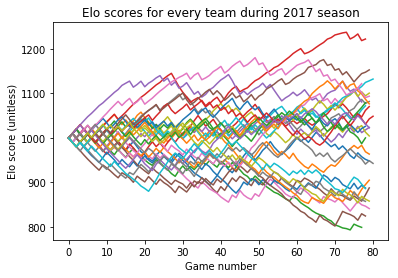

In [11]:
for t in data['team'].unique():
    plt.plot(elo_over_time[2017][t], label=t)

# plt.savefig('elos_over_2016.pdf')
plt.ylabel('Elo score (unitless)')
plt.xlabel('Game number')
plt.title('Elo scores for every team during 2017 season')
plt.show()

In [22]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

#  try out fitting two very different types of models
model = linear_model.LogisticRegression(solver='lbfgs', max_iter=500) 
random_forest = RandomForestClassifier(n_estimators=200)

season = np.array(season,dtype='int')

# splitting up train and test data
train = np.array(season) != 2017
test = np.array(season) == 2017

model.fit(np.array(X)[train], np.array(y)[train])
random_forest.fit(np.array(X)[train], np.array(y)[train])

print('Model done fitting!')
print('Logistic Regression Training Accuracy %.3f'%(model.score(np.array(X)[train,:],np.array(y)[train])))
print('Random Forest Training Accuracy %.3f'%(random_forest.score(np.array(X)[train,:],np.array(y)[train])))
# print(random_forest.feature_importances_)

Model done fitting!
Logistic Regression Training Accuracy 0.663
Random Forest Training Accuracy 1.000


In [23]:
print ('2017 Season Test Accuracy (Logistic Regression) %.3f'%(model.score(np.array(X)[test,:],np.array(y)[test])))
print ('2017 Season Test Accuracy (Random Forest) %.3f'%(random_forest.score(np.array(X)[test,:],np.array(y)[test])))

2017 Season Test Accuracy (Logistic Regression) 0.660
2017 Season Test Accuracy (Random Forest) 0.639


Trained on data from the 2009 - 2016 seasons, I can predict the outcome of the 2017 season with >65% accuracy.  For fun, I also trained and scored a Random Forest classifier.  As it stands, most of the stats don't make particularly good predictors.  Just by playing around with the list of predictors, I've settled on the few used to generate these results.  There is certainly more to be done in the way of feature selection and then there is also more cross validation to be done. 